# ADCP Disharge Example

This example notebook overviews how to calculate discharge from an ADCP transect. The example data used in this notebook was taken by a Teledyne RDI RiverPro ADCP, an instrument purpose-built for calculating discharge from a survey transect, but the following workflow can be used with any ADCP's data, given that there is GPS information and/or bottom track measurements stored in the ADCP file.

The basic steps that the notebook conducts are to
1. Read in the binary ADCP file
2. Rotate the dataset into the Earth coordinate system ("East", "North", "Up")
3. Correct vessel motion using stored bottom track (You can also use the GPS's velocity measurement, found from the VTG sentence and converted from speed and direction to velocity-east and velocity-north)
4. Rotate the dataset into the water current's principal coordinate system ("streamwise", "cross-stream", "vertical")
5. Calculate the distance from the ADCP to the riverbed/seabed. (We use the bottom track ping here, but can also use the ADCP's altimeter, if available)
6. Finally, calculate the water discharge. Additional parameters that are not availble within the ADCP's dataset are required here.

We'll start by immediately jumping through steps 1 and 2. Note if that quality control is required, that should be done here.


In [1]:
from mhkit import dolfyn

ds = dolfyn.read_example("RiverPro_test01.PD0")
ds.velds.set_declination(18)  # Set declination to 18 degrees East
ds.velds.rotate2("earth")

# # Note, if the range coordinate has not been adjusted given the depth of the ADCP 
# # below the waterline, do so using the following line.
# ds = dolfyn.adp.clean.set_range_offset(ds, x.x)  # Set range offset to x.x m


Reading file c:\users\mcve343\mhkit-python\examples\data\dolfyn/RiverPro_test01.PD0 ...


We can plot the dataset below so we know what we are looking at

[Text(0, 0.5, 'Depth [m]')]

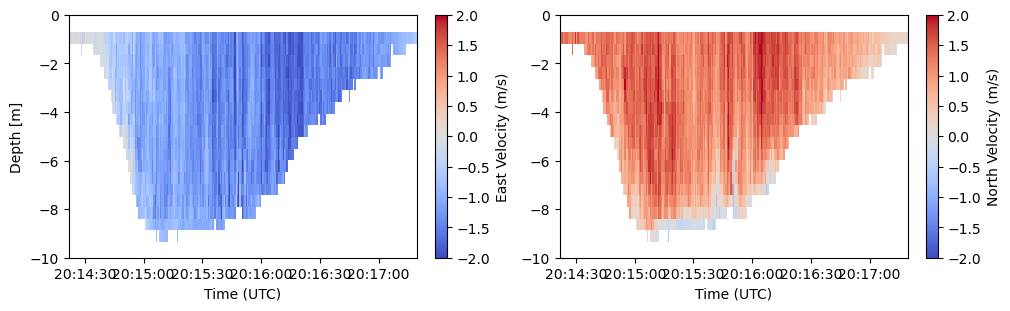

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,3), constrained_layout=True)
e = ax[0].pcolormesh(ds["time"].values, -ds["range"].values, ds["vel"][0], cmap="coolwarm", vmin=-2, vmax=2)
n = ax[1].pcolormesh(ds["time"].values, -ds["range"].values, ds["vel"][1], cmap="coolwarm", vmin=-2, vmax=2)
fig.colorbar(e, ax=ax[0], label="East Velocity (m/s)")
fig.colorbar(n, ax=ax[1], label="North Velocity (m/s)")
for a in ax:
    a.set(xlabel="Time (UTC)", ylim=(-10, 0))
ax[0].set(ylabel="Depth [m]")

The next step we need to do is to make sure we correct the ADCP measurement for the vessel motion. This is not done natively in the raw ADCP file.

In [3]:
# Correct velocity
ds["vel_bt"] = ds["vel_bt"].where((ds["vel_bt"] < 5) & (ds["vel_bt"] > -5))
ds["vel"] -= ds["vel_bt"]

Then rotate into principal coordinates.

In [4]:
# Rotate to principal reference frame
ds.attrs["principal_heading"] = dolfyn.calc_principal_heading(ds["vel"].mean("range"))
ds.velds.rotate2("principal")

And replot...

The sign associated with the streamwise velocity is a byproduct of the principal direction calculation; it should be associated with ebb or flood tide based on visual observation. The sign associated with the cross-stream (transverse) velocity is related to the streamwise velocity by the right-hand-rule.

[Text(0, 0.5, 'Depth [m]')]

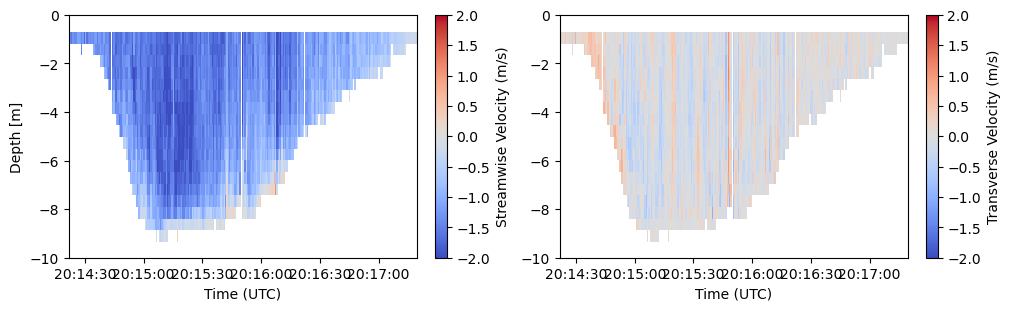

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,3), constrained_layout=True)
s = ax[0].pcolormesh(ds["time"].values, -ds["range"].values, ds["vel"][0], cmap="coolwarm", vmin=-2, vmax=2)
t = ax[1].pcolormesh(ds["time"].values, -ds["range"].values, ds["vel"][1], cmap="coolwarm", vmin=-2, vmax=2)
fig.colorbar(s, ax=ax[0], label="Streamwise Velocity (m/s)")
fig.colorbar(t, ax=ax[1], label="Transverse Velocity (m/s)")
for a in ax:
    a.set(xlabel="Time (UTC)", ylim=(-10, 0))
ax[0].set(ylabel="Depth [m]")

Next step is to calculate the water depth from one of the ADCP's measurements. This can come from the bottom track ping, an altimeter ping, or an external depth sounder. You may need to do some quality control on this measurement, and make sure to add the `range_offset`, the depth of the ADCP below the waterline, to this array.

In [6]:
# Find the water depth based on the average bottom track pings
water_depth = ds.attrs["range_offset"] + ds["dist_bt"].mean("beam").values

And we can superimpose that on our plot.

[Text(0, 0.5, 'Depth [m]')]

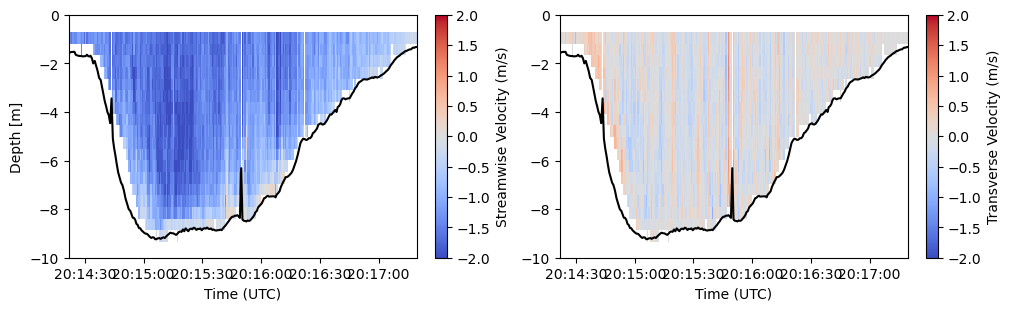

In [7]:
fig, ax = plt.subplots(1,2, figsize=(10,3), constrained_layout=True)
s = ax[0].pcolormesh(ds["time"].values, -ds["range"].values, ds["vel"][0], cmap="coolwarm", vmin=-2, vmax=2)
t = ax[1].pcolormesh(ds["time"].values, -ds["range"].values, ds["vel"][1], cmap="coolwarm", vmin=-2, vmax=2)
ax[0].plot(ds["time"].values, -water_depth, color="k", label="Water Depth")
ax[1].plot(ds["time"].values, -water_depth, color="k", label="Water Depth")
fig.colorbar(s, ax=ax[0], label="Streamwise Velocity (m/s)")
fig.colorbar(t, ax=ax[1], label="Transverse Velocity (m/s)")
for a in ax:
    a.set(xlabel="Time (UTC)", ylim=(-10, 0))
ax[0].set(ylabel="Depth [m]")

Now we can use the `discharge` function to calculate discharge, among other values (including power [W], power density [W/m^2], and the channel's Reynolds Number). This function does quite a number of things internally:
1. Linearly extrapolates velocity to the riverbed/seafloor (assumes velocity at the seafloor, specified by the "water_depth" input, is 0 m/s)
2. Constant extrapolation of velocity to the water surface (water velocity at the uppermost bin is the same speed as that at the water surface)
3. Remaps the velocity transect from "time" onto "distance" based on the GPS-measured location (`latitude_gps` and `longitude_gps` variables). It does this by converting the lat/lon to UTM and interpolating the UTM location onto the timegrid.
4. Velocity data is then integrated over the cross-sectional area to find discharge [m^3/s], power [W], power density [W/m^2], and hydraulic depth [m]. The last is used to find the Reynolds Number. 
5. Values are saved into the returned dataset

The inputs are as follows:
1. `ds` - ADCP dataset
2. `water_depth` - as calculated above
3. `rho` - water density for the water current in question
4. `mu` - kinematic viscosity, based on the water temperature and salinity. Can be found from a look-up table online.
5. `surface_offset` - Location of water surface on a vertical datum. Typically will be 0 for a river. In a tidal channel, this will depend on the height of the tide relative to MLLW (or MSL or desired level) at the time of the transect measurement. If the water level during the transect is above MLLW, this value will be negative. If above MLLW, this value will be positive.
6. `utm_zone` - UTM zone at the survey location. Can easily be found for a specific location by searching here: https://www.usgs.gov/media/images/mapping-utm-grid-conterminous-48-united-states

In [8]:
# Calculate discharge, power, power density, and the Reynolds number of the channel
dolfyn.adp.api.discharge(ds, water_depth, rho=1020, mu=0.0012, surface_offset=0, utm_zone=5)

<xarray.Dataset> Size: 236kB
Dimensions:              (time: 262, time_gps: 262, range: 24, range_sl: 5,
                          beam: 4, dir: 4, x1: 4, x2: 4, earth: 3, inst: 3)
Coordinates:
  * time                 (time) datetime64[ns] 2kB 2022-08-19T20:14:21.930000...
  * time_gps             (time_gps) datetime64[ns] 2kB 2022-08-19T20:14:23.59...
  * range                (range) float32 96B 0.95 1.43 1.91 ... 11.51 11.99
  * range_sl             (range_sl) float64 40B 0.54 0.66 0.78 0.9 1.02
  * beam                 (beam) int32 16B 1 2 3 4
  * dir                  (dir) <U10 160B 'streamwise' 'x-stream' 'vert' 'err'
  * x1                   (x1) int32 16B 1 2 3 4
  * x2                   (x2) int32 16B 1 2 3 4
  * earth                (earth) <U1 12B 'E' 'N' 'U'
  * inst                 (inst) <U1 12B 'X' 'Y' 'Z'
Data variables: (12/47)
    number               (time) uint32 1kB 398 399 400 401 ... 656 657 658 659
    builtin_test_fail    (time) bool 262B False False False ... False False
    c_sound              (time) float32 1kB 1.458e+03 1.458e+03 ... 1.459e+03
    depth                (time) float32 1kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    pitch                (time) float32 1kB -1.21 -1.01 -1.46 ... -0.5 -0.57
    roll                 (time) float32 1kB 1.97 0.49 1.07 ... -0.66 -0.53 0.72
    ...                   ...
    beam2inst_orientmat  (x1, x2) float32 64B 1.462 -1.462 0.0 ... -1.034 -1.034
    orientmat            (earth, inst, time) float32 9kB -0.8992 ... 0.9999
    discharge            float32 4B -1.136e+03
    power                float32 4B -1.211e+06
    power_density        float32 4B -1.307e+03
    reynolds_number      float32 4B 6.2e+06
Attributes: (12/46)
    prog_ver:                  56.1
    inst_make:                 TRDI
    inst_type:                 ADCP
    rotate_vars:               ['vel', 'vel_sl', 'vel_bt']
    has_imu:                   0
    inst_model:                RiverPro
    ...                        ...
    range_offset:              0.37
    blank_dist_sl:             0.05
    fs:                        1.47
    declination:               18
    declination_in_orientmat:  1
    principal_heading:         173.522